# Judul: Peramalan nilai Air Quality Index (AQI) berdasarkan data historis AQI kota jakarta dari tahun 2010-2021

## Problem Overview:

Dataset yang saya gunakan adalah dataset tentang Air Quality Index (AQI) di kota Jakarta dari tahun 2010-2021 (https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021/data). Dataset ini terdiri dari 5 file csv yang menggambarkan 5 titik dimana data ini diambil. Antara lain:

1.   ispu_dki1: titik pengukuran ada di Bundaran HI
2.   ispu_dki2: titik pengukuran ada di Kelapa Gading
3.   ispu_dki3: titik pengukuran ada di Jagakarsa
4.   ispu_dki4: titik pengukuran ada di Lubang Buaya
5.   ispu_dki5: titik pengukuran ada di Kebon Jeruk

Kategorisasi berdasarkan nilai pada kolom max:
1. 0 - 50 = BAIK
2. 51 - 100 = SEDANG
3. 100 - 150 = TIDAK SEHAT

Adapun kolom yang tersedia, penjelasannya adalah sebagai berikut:
1.   tanggal: tanggal pengukuran AQI
2.   stasiun: titik tempat pengukuran  
3.   pm10: particulate matter dengan ukuran antara 2.5 hingga 10 mikron (fitur)  
4.   pm25: particulate matter dengan ukuran lebih kecil atau sama dengan 2.5 mikron (fitur)  
5.   so2: kandungan sulfide (fitur)  
6.   co: kandungan karbon monoksida (fitur)  
7.   o3: kandungan ozone (fitur)
8.   no2: kandungan nitrogen dioksida
9.   max: nilai maksimal dari semua parameter atau fitur (Target untuk menentukan kategori)
10.  critical: parameter/fitur yang memiliki nilai maksimal diantara lainnya
11.  category: kategori target yg disimpulkan dari klasifikasi berdasarkan nilai fitur. (target)

Dataset menggambarkan nilai harian, dan nilai dari fitur merupakan pengukuran dari 1m kubik udara. Semakin besar nilai dari fitur berarti semakin rendah kualitas dari udara yang dihirup. Nilai dari fitur merupakan hasil rata-rata dari pengukuran yang dilakukan pada tanggal tersebut.

Yang saya lakukan di final project ini adalah melakukan prediksi menggunakan regresi tentang kategori dari hasil pengukuran AQI. Langkah-langkah yang dilakukan adalah sebagai berikut:
1.   Data Preprocessing:
2.   EDA
3.   Mencoba menggunakan Ridge dan Lasso Regression pada dataset yang sudah dibersihkan. Hyperparameter tuning untuk memilih parameter tuning yang terbaik
4.   Melakukan evaluasi terhadap model (Ridge dan Lasso Regression)
5.   Jika masih ada waktu, melakukan analisa korelasi untuk menghilangkan fitur yang memiliki korelasi tinggi satu sama lain
6.   Melakukan RIdge dan Lasso Regression dan Hyperparameter tuning lagi
7.   Evaluasi Model mana yang lebih baik antara no 3 atau 6

Berdasarkan feedback dari mentor, ternyata data saya termasuk time series sehingga tidak disarankan menggunakan regresi linier. Mentor menyarankan mengubah metode menjadi ARIMA atau SARIMA.

Setelah saya melakukan studi literatur dan membaca beberapa buku dan jurnal, ternyata metode ARIMA atau SARIMA tidak bisa digunakan. Hal ini dikarenakan ada beberapa fitur lain yang juga ada dan berpengaruh terhadap hasil akhir nilai AQI. Kesimpulan yang saya dapatkan adalah dataset saya jika dilakukan peramalan, maka termasuk peramalan time series yang bersifat multivariate. ARIMA atau SARIMA masuk metode peramalan time series yang bersifat univariate. Sehingga saya harus mencari lagi metode yang cocok digunakan dalam peramalan time series multivariate.

Saya menemukan beberapa metode, antara lain:
1.   VAR (Vector Auto Regressive)
2.   Random Forest Regressor
3.   XGBoost Regressor

Dikarenakan keterbatasan waktu untuk belajar semua metode diatas maka saya memilih menggunakan metode pertama yakni **VAR (Vector Auto Regression)**

Langkah-langkah yang saya lakukan berikutnya adalah sebagai berikut:
1. Data Preprocessing: Melakukan pengecekan terhadap nilai kosong dan melakukan drop terhadap kolom yang tidak digunakan dalam forecasting (station, critical, category), merubah kolom tanggal menjadi datetime. Target kolom adalah max.
2. Melakukan pengecekan untuk stationarity pada setiap fitur yang akan digunakan, yakni: pm10, pm25, so2, co, o3, no2
3. Melakukan split untuk data train dan test
4. Melakukan grid search untuk mencari nilai order P yang terbaik
5. Predict test data
6. Invert transformasi
7. Plot terhadap hasil prediksi
8. Evaluasi Model menggunakan RMSE, semakin kecil maka semakin bagus.






In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR,adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels as sm
import matplotlib as mp

In [4]:
#import dataset
import os
file_dirs = "/content/drive/Othercomputers/My Laptop (1)/GoogleDrive/Dibimbing/Day 36 - Final Project/Dataset"
os.chdir(file_dirs)

In [5]:
# Repress setting withcopywarning error
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
df_dki1 = pd.read_csv('ispu_dki1.csv',index_col='tanggal', parse_dates=True)
df_dki2 = pd.read_csv('ispu_dki2.csv',index_col='tanggal', parse_dates=True)
df_dki3 = pd.read_csv('ispu_dki3.csv',index_col='tanggal', parse_dates=True)
df_dki4 = pd.read_csv('ispu_dki4.csv',index_col='tanggal', parse_dates=True)
df_dki5 = pd.read_csv('ispu_dki5.csv',index_col='tanggal', parse_dates=True)

In [7]:
df_dki1.index = pd.DatetimeIndex(df_dki1.index).to_period('D')

## Data Preprocessing

###Data Exploration
ispu_dki1:

Jumlah data: 4383
Data duplikat: 0
Data null: 4018 di pm25, fitur lain maksimal di 212
ispu_dki2:

Jumlah data: 4383
Data duplikat: 0
Data null: 4034 di pm25, fitur lain maksimal di 479
ispu_dki3:

Jumlah data: 4383
Data duplikat: 0
Data null: 4025 di pm25, fitur lain maksimal di 621
ispu_dki4:

Jumlah data: 4383
Data duplikat: 0
Data null: 4060 di pm25, fitur lain maksimal di 697
ispu_dki5:

Jumlah data: 4383
Data duplikat: 0
Data null: 4053 di pm25, fitur lain maksimal di 1271

In [8]:
df_dki1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4383 entries, 2010-01-01 to 2021-12-31
Freq: D
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   stasiun   4383 non-null   object 
 1   pm10      4171 non-null   float64
 2   so2       4208 non-null   float64
 3   co        4233 non-null   float64
 4   o3        4180 non-null   float64
 5   no2       4190 non-null   float64
 6   max       4374 non-null   float64
 7   critical  4273 non-null   object 
 8   categori  4383 non-null   object 
 9   pm25      365 non-null    float64
dtypes: float64(7), object(3)
memory usage: 376.7+ KB


In [9]:
df_dki1.head()

,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
tanggal,,,,,,,,,,
2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG,NaN
2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK,NaN
2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK,NaN
2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK,NaN
2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK,NaN


In [10]:
df_dki1.describe()

,pm10,so2,co,o3,no2,max,pm25
count,4171.000000,4208.000000,4233.000000,4180.000000,4190.000000,4374.000000,365.000000
mean,52.226325,18.091017,24.852351,49.514593,14.107637,60.741198,69.073973
std,14.578838,10.755446,11.153177,25.784704,8.948707,22.150779,18.117065
min,4.000000,1.000000,3.000000,3.000000,1.000000,0.000000,20.000000
25%,43.000000,10.000000,17.000000,29.000000,7.000000,49.000000,57.000000
50%,54.000000,17.000000,24.000000,46.000000,14.000000,60.000000,70.000000
75%,62.000000,25.000000,31.000000,66.000000,19.000000,73.000000,81.000000
max,104.000000,106.000000,95.000000,198.000000,79.000000,198.000000,112.000000


In [11]:
df_dki1.duplicated().sum()

110

In [12]:
df_dki1.isnull().sum()

stasiun        0
pm10         212
so2          175
co           150
o3           203
no2          193
max            9
critical     110
categori       0
pm25        4018
dtype: int64

### Data Selection

Berdasarkan data introduction, saya memutuskan untuk menggunakan csv yang **ispu_dki1** karena memiliki jumlah null di **pm25** paling kecil dan fitur lain yg null juga paling kecil maksimal nya, yakni **212**, jika dibandingkan dengan csv lainnya. Tidak sampai **4%** dari total jumlah data.

## Data Preprocessing pada ispu_dki1
1. Identifikasi kolom yang memiliki null value: pm25
2. Mengubah data yang kosong pada kolom pm10, so2, co, o3, no2 menjadi nilai rata rata berdasarkan masing-masing kategori dan menghapus data yang tidak memiliki nilai
3. Menghilangkan beberapa kolom yang tidak diperlukan, yakni station, critical, dan categori karena tidak mempengaruhi nilai max.
4. menjadikan kolom max sebagai target
5. menjadikan kolom pm10, so2, co, o3, no2 dan pm25 sebagai fitur

In [13]:
df_dki1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4383 entries, 2010-01-01 to 2021-12-31
Freq: D
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   stasiun   4383 non-null   object 
 1   pm10      4171 non-null   float64
 2   so2       4208 non-null   float64
 3   co        4233 non-null   float64
 4   o3        4180 non-null   float64
 5   no2       4190 non-null   float64
 6   max       4374 non-null   float64
 7   critical  4273 non-null   object 
 8   categori  4383 non-null   object 
 9   pm25      365 non-null    float64
dtypes: float64(7), object(3)
memory usage: 376.7+ KB


In [14]:
# 1. Identifikasi kolom yang memiliki null value: pm25
df_dki1.isnull().sum()

stasiun        0
pm10         212
so2          175
co           150
o3           203
no2          193
max            9
critical     110
categori       0
pm25        4018
dtype: int64

In [15]:
#Lihat unique value dari pm25
df_dki1['pm25'].unique()

array([ nan,  53.,  46.,  58.,  48.,  47.,  54.,  61.,  25.,  50.,  44.,
        57.,  62.,  73.,  71.,  52.,  41.,  34.,  51.,  63., 108.,  82.,
        70.,  20.,  37.,  79.,  33.,  36.,  23.,  26.,  40.,  38.,  28.,
        59.,  45.,  67.,  64.,  42.,  60.,  55.,  75.,  69.,  88.,  65.,
        35.,  80.,  93., 102.,  77.,  78.,  66.,  68.,  74.,  76., 101.,
        92.,  83.,  87.,  81.,  99.,  86.,  94.,  84., 110.,  72.,  91.,
        89., 109.,  90., 106.,  95.,  97., 100.,  85., 105.,  96., 112.,
        56.,  49.,  39.,  30.,  31.,  43.])

In [16]:
# mencari nilai rata rata per kategori untuk menggantikan nilai pm25 yang kosong
df_dki1.groupby('categori')['pm25'].transform('mean')

tanggal
2010-01-01    73.078231
2010-01-02    39.421053
2010-01-03    39.421053
2010-01-04    39.421053
2010-01-05    39.421053
                ...    
2021-12-27    73.078231
2021-12-28    73.078231
2021-12-29    73.078231
2021-12-30    73.078231
2021-12-31    73.078231
Freq: D, Name: pm25, Length: 4383, dtype: float64

In [17]:
# 1. mengisi kekosongan data pada kolom pm25 menggunakan rata rata per kategori pada kolom max
df_dki1['pm25'] = df_dki1.groupby('categori')['max'].transform(lambda x: x.fillna(x.mean()))

In [18]:
df_dki1.isnull().sum()

stasiun       0
pm10        212
so2         175
co          150
o3          203
no2         193
max           9
critical    110
categori      0
pm25          0
dtype: int64

In [19]:
# ada 110 baris yang memang data hasil pengukuran kosong semua, terpaksa dihapus
df_dki1[df_dki1['pm25'].isnull()]

,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
tanggal,,,,,,,,,,


In [20]:
# hapus semua baris pm25, pm10 yang memiliki null value
df_dki1 = df_dki1.dropna(subset=['pm25'])
df_dki1 = df_dki1.dropna(subset=['pm10'])

In [21]:
# cek lagi null value, turun banyak kolom yang memiliki null value
df_dki1.isnull().sum()

stasiun      0
pm10         0
so2         62
co          30
o3          87
no2         66
max          0
critical     0
categori     0
pm25         0
dtype: int64

In [22]:
#Lakukan hal yang sama pada kolom pm10, so2, co, o3, no2
df_dki1['pm10'] = df_dki1.groupby('categori')['pm10'].transform(lambda x: x.fillna(x.mean()))
df_dki1['so2'] = df_dki1.groupby('categori')['so2'].transform(lambda x: x.fillna(x.mean()))
df_dki1['co'] = df_dki1.groupby('categori')['co'].transform(lambda x: x.fillna(x.mean()))
df_dki1['o3'] = df_dki1.groupby('categori')['o3'].transform(lambda x: x.fillna(x.mean()))
df_dki1['no2'] = df_dki1.groupby('categori')['no2'].transform(lambda x: x.fillna(x.mean()))

In [23]:
df_dki1[df_dki1['pm10'].isnull()]

,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
tanggal,,,,,,,,,,


In [24]:
df_dki1.head()

,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
tanggal,,,,,,,,,,
2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG,73.0
2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK,33.0
2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK,27.0
2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK,22.0
2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK,25.0


In [25]:
# 3. Menghilangkan beberapa kolom yang tidak diperlukan, yakni station, critical karena tidak mempengaruhi nilai max.
df_dki1 = df_dki1.drop(columns=['stasiun','critical'])

In [26]:
df_dki1['pm10'].unique()

array([ 60.,  32.,  27.,  22.,  25.,  30.,  41.,  64.,  55.,  34.,  45.,
        28.,  38.,  35.,  54.,  44.,  40.,  61.,  36.,  51.,  56.,  59.,
        43.,  72.,  47.,  50.,  49.,  63.,  65.,  46.,  52.,  37.,  57.,
        68.,  67.,  74.,  62.,  58.,  48.,  39.,  70.,  66.,  29.,  31.,
        76.,  53.,  69.,  77.,  79.,  75.,  81.,  24.,  33.,  42.,  78.,
        21.,  23.,  26.,  82.,  71.,  73.,  89.,  80.,  83.,  11.,   8.,
         9.,   6.,  12.,   7.,  15.,  13.,  18.,  19.,  20., 103.,  87.,
        86.,  85.,  94.,  88.,  84.,  92.,  17.,  10.,  16.,  90., 104.,
         5.,  14.,   4.])

In [27]:
df_dki1.isnull().sum()

pm10        0
so2         0
co          0
o3          0
no2         0
max         0
categori    0
pm25        0
dtype: int64

In [42]:
df_dki1.head()

,pm10,so2,co,o3,no2,max,categori,pm25
tanggal,,,,,,,,
2010-01-01,60.0,4.0,73.0,27.0,14.0,73.0,SEDANG,73.0
2010-01-02,32.0,2.0,16.0,33.0,9.0,33.0,BAIK,33.0
2010-01-03,27.0,2.0,19.0,20.0,9.0,27.0,BAIK,27.0
2010-01-04,22.0,2.0,16.0,15.0,6.0,22.0,BAIK,22.0
2010-01-05,25.0,2.0,17.0,15.0,8.0,25.0,BAIK,25.0


## Exploratory Data Analysis

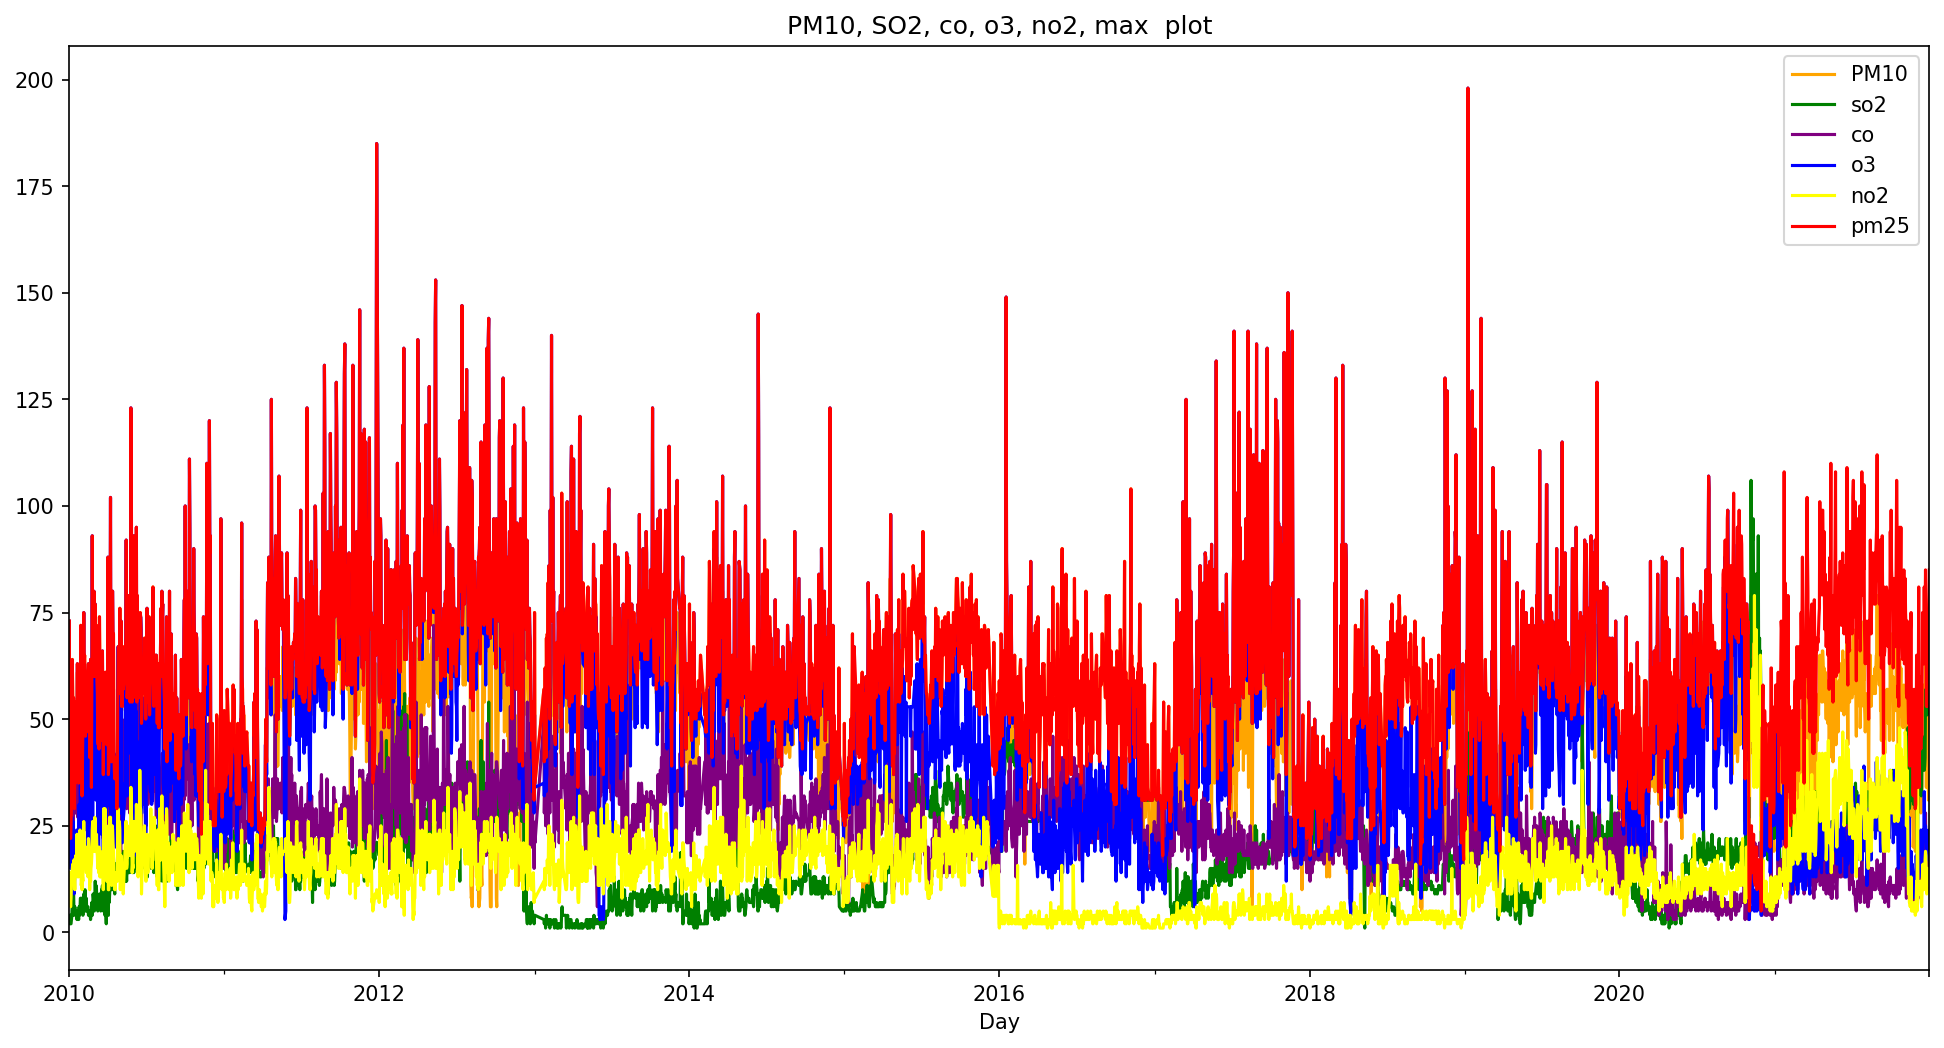

In [28]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

df_dki1['pm10'].plot(label='PM10', color='orange')
df_dki1['so2'].plot(label='so2', color='green')
df_dki1['co'].plot(label='co', color='purple')
df_dki1['o3'].plot(label='o3', color='blue')
df_dki1['no2'].plot(label='no2', color='yellow')
df_dki1['pm25'].plot(label='pm25', color='red')

# adding title to the plot
plt.title('PM10, SO2, co, o3, no2, max  plot')

# adding Label to the x-axis
plt.xlabel('Day')

# adding legend to the curve
plt.legend()

<Axes: xlabel='tanggal'>

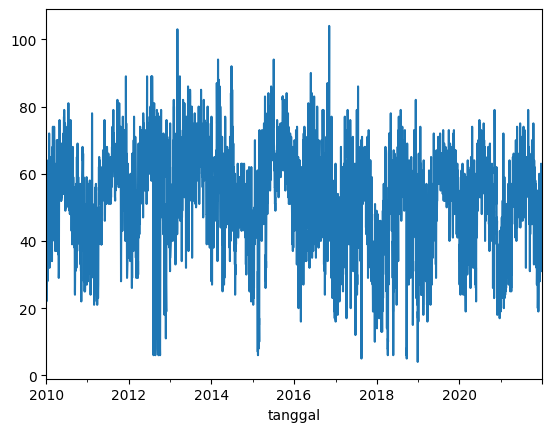

In [49]:
seriespm10 = df_dki1['pm10']
seriespm10.plot()

<Axes: xlabel='tanggal'>

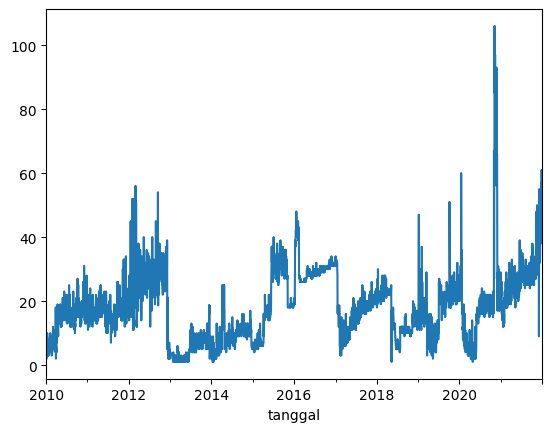

In [30]:
seriess02 = df_dki1['so2']
seriess02.plot()

<Axes: xlabel='tanggal'>

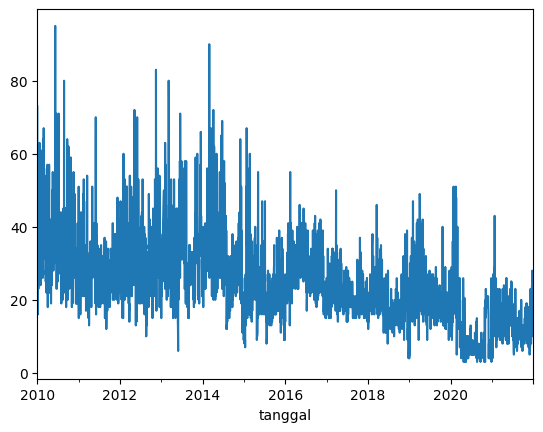

In [37]:
seriesco = df_dki1['co']
seriesco.plot()

<Axes: xlabel='tanggal'>

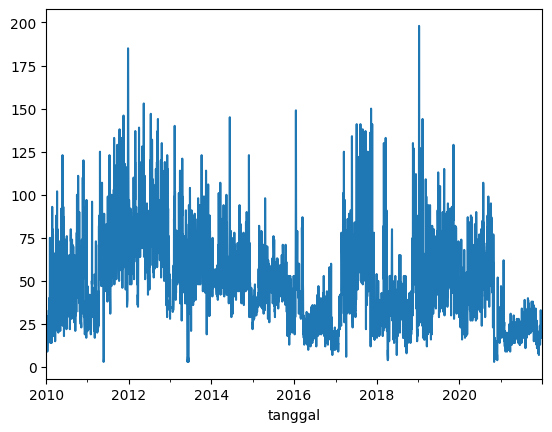

In [38]:
serieso3 = df_dki1['o3']
serieso3.plot()

<Axes: xlabel='tanggal'>

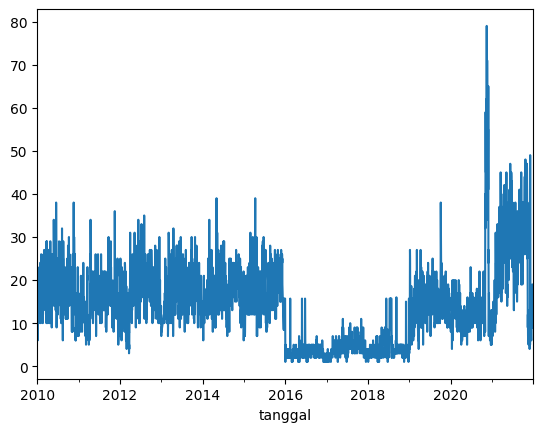

In [39]:
seriesno2 = df_dki1['no2']
seriesno2.plot()

<Axes: xlabel='tanggal'>

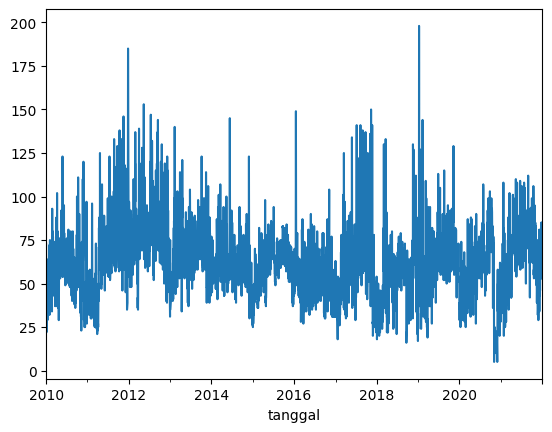

In [40]:
seriespm25 = df_dki1['pm25']
seriespm25.plot()

<Axes: xlabel='tanggal'>

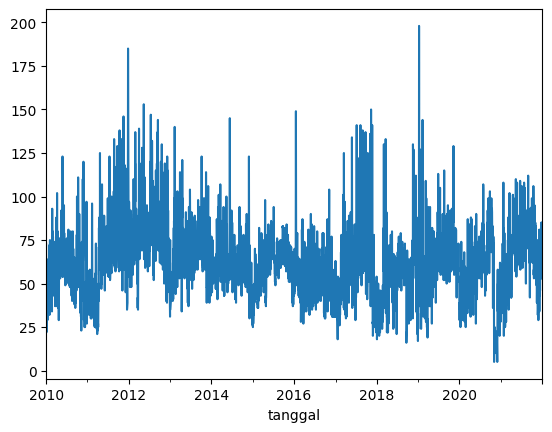

In [41]:
seriesmax = df_dki1['max']
seriesmax.plot()

## Melakukan pengecekan untuk stationarity pada setiap fitur yang akan digunakan, yakni: pm10, pm25, so2, co, o3, no2 dan target yakni max

In [51]:
# Membuat dataframe baru untuk pengecekan stationary pada setiap fitur
df_dki1_fitur = df_dki1[['pm10', 'so2','co','o3','no2','pm25']].copy()
df_dki1_fitur

,pm10,so2,co,o3,no2,pm25
tanggal,,,,,,
2010-01-01,60.0,4.0,73.0,27.0,14.0,73.0
2010-01-02,32.0,2.0,16.0,33.0,9.0,33.0
2010-01-03,27.0,2.0,19.0,20.0,9.0,27.0
2010-01-04,22.0,2.0,16.0,15.0,6.0,22.0
2010-01-05,25.0,2.0,17.0,15.0,8.0,25.0
...,...,...,...,...,...,...
2021-12-27,52.0,61.0,15.0,20.0,15.0,71.0
2021-12-28,51.0,53.0,15.0,18.0,13.0,65.0
2021-12-29,31.0,54.0,10.0,24.0,11.0,54.0


In [50]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)

    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'

    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non-stationary'
    return (kpssh, adfh)

In [52]:
for i in df_dki1_fitur:
    kps, adf = check_stationarity(df_dki1_fitur[i])
    print(f'{i} adf: {adf}, kpss: {kps}')

<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)


pm10 adf: Stationary, kpss: Non-stationary
so2 adf: Stationary, kpss: Non-stationary


<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)
<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)


co adf: Stationary, kpss: Non-stationary


<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)


o3 adf: Stationary, kpss: Non-stationary


<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)


no2 adf: Stationary, kpss: Non-stationary
pm25 adf: Stationary, kpss: Non-stationary


Berdasarkan pengujian stationary menggunakan 2 metode, yakni adf dan kpss. dapat diambil kesimpulan bahwa dengan menggunakan metode **adf** atau **Augmented Dickey Fuller** semua fitur sudah stationary dengan nilai p dibawah 0.05. Namun metode **kpss Kwiatkowski-Phillips-Schmidt-Shin** menunjukkan semua fitur adalah non-stationary.

Hasil ini menunjukkan bahwa semua series pada fitur adalah difference stationary. differencing harus dilakukan terlebih dahulu untuk membuat data time series menjadi stationar

In [53]:
# Mengaplikasikan differencing pada data time series
df_dki1_fitur['pm10_diff'] = df_dki1_fitur['pm10'] - df_dki1_fitur['pm10'].shift(1)
df_dki1_fitur['so2_diff'] = df_dki1_fitur['so2'] - df_dki1_fitur['so2'].shift(1)
df_dki1_fitur['co_diff'] = df_dki1_fitur['co'] - df_dki1_fitur['co'].shift(1)
df_dki1_fitur['o3_diff'] = df_dki1_fitur['o3'] - df_dki1_fitur['o3'].shift(1)
df_dki1_fitur['no2_diff'] = df_dki1_fitur['no2'] - df_dki1_fitur['no2'].shift(1)
df_dki1_fitur['pm25_diff'] = df_dki1_fitur['pm25'] - df_dki1_fitur['pm25'].shift(1)
df_dki1_fitur

,pm10,so2,co,o3,no2,pm25,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,,,,,,,
2010-01-01,60.0,4.0,73.0,27.0,14.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,32.0,2.0,16.0,33.0,9.0,33.0,-28.0,-2.0,-57.0,6.0,-5.0,-40.0
2010-01-03,27.0,2.0,19.0,20.0,9.0,27.0,-5.0,0.0,3.0,-13.0,0.0,-6.0
2010-01-04,22.0,2.0,16.0,15.0,6.0,22.0,-5.0,0.0,-3.0,-5.0,-3.0,-5.0
2010-01-05,25.0,2.0,17.0,15.0,8.0,25.0,3.0,0.0,1.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,52.0,61.0,15.0,20.0,15.0,71.0,17.0,10.0,4.0,-2.0,5.0,18.0
2021-12-28,51.0,53.0,15.0,18.0,13.0,65.0,-1.0,-8.0,0.0,-2.0,-2.0,-6.0
2021-12-29,31.0,54.0,10.0,24.0,11.0,54.0,-20.0,1.0,-5.0,6.0,-2.0,-11.0


In [54]:
df_dki1_fitur = df_dki1_fitur.dropna(subset=['pm10_diff'])
df_dki1_fitur_diff = df_dki1_fitur[['pm10_diff', 'so2_diff','co_diff','o3_diff','no2_diff','pm25_diff']].copy()
df_dki1_fitur_diff

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,
2010-01-02,-28.0,-2.0,-57.0,6.0,-5.0,-40.0
2010-01-03,-5.0,0.0,3.0,-13.0,0.0,-6.0
2010-01-04,-5.0,0.0,-3.0,-5.0,-3.0,-5.0
2010-01-05,3.0,0.0,1.0,0.0,2.0,3.0
2010-01-06,5.0,1.0,5.0,4.0,3.0,5.0
...,...,...,...,...,...,...
2021-12-27,17.0,10.0,4.0,-2.0,5.0,18.0
2021-12-28,-1.0,-8.0,0.0,-2.0,-2.0,-6.0
2021-12-29,-20.0,1.0,-5.0,6.0,-2.0,-11.0


In [55]:
# Semua data fitur sudah dilakukan differencing dan semua nya stationary berdasarkan adf dan kpss
for i in df_dki1_fitur_diff:
    kps, adf = check_stationarity(df_dki1_fitur[i])
    print(f'{i} adf: {adf}, kpss: {kps}')

<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)
<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)


pm10_diff adf: Stationary, kpss: Stationary
so2_diff adf: Stationary, kpss: Stationary
co_diff adf: Stationary, kpss: Stationary


<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)
<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)


o3_diff adf: Stationary, kpss: Stationary


<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)


no2_diff adf: Stationary, kpss: Stationary
pm25_diff adf: Stationary, kpss: Stationary


<ipython-input-50-f99cc58a1dac>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)


## Split into train test

In [56]:
df_dki1_fitur_diff.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4170 entries, 2010-01-02 to 2021-12-31
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pm10_diff  4170 non-null   float64
 1   so2_diff   4170 non-null   float64
 2   co_diff    4170 non-null   float64
 3   o3_diff    4170 non-null   float64
 4   no2_diff   4170 non-null   float64
 5   pm25_diff  4170 non-null   float64
dtypes: float64(6)
memory usage: 228.0 KB


In [57]:
df_dki1_fitur_diff.index

PeriodIndex(['2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05',
             '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09',
             '2010-01-10', '2010-01-11',
             ...
             '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
             '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
             '2021-12-30', '2021-12-31'],
            dtype='period[D]', name='tanggal', length=4170)

In [58]:
# Total data tersisa setelah dilakukan preprocessing dan cek stationary adalah 4.272 data.
# Saya akan membagi sebanyak 80% (3307) data training dan 20% (966) data testing.
train = df_dki1_fitur_diff.loc[:'2019-05-01']
test = df_dki1_fitur_diff.loc['2019-05-01':]

train

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,
2010-01-02,-28.0,-2.0,-57.0,6.0,-5.0,-40.0
2010-01-03,-5.0,0.0,3.0,-13.0,0.0,-6.0
2010-01-04,-5.0,0.0,-3.0,-5.0,-3.0,-5.0
2010-01-05,3.0,0.0,1.0,0.0,2.0,3.0
2010-01-06,5.0,1.0,5.0,4.0,3.0,5.0
...,...,...,...,...,...,...
2019-04-27,11.0,1.0,9.0,-35.0,-11.0,-23.0
2019-04-28,5.0,-2.0,11.0,6.0,0.0,5.0
2019-04-29,4.0,2.0,-7.0,10.0,8.0,4.0


In [59]:
test

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,
2019-05-01,7.0,-1.0,-5.0,6.0,-10.0,6.0
2019-05-02,-22.0,2.0,-10.0,-35.0,-6.0,-27.0
2019-05-03,14.0,10.0,10.0,23.0,11.0,15.0
2019-05-04,10.0,-3.0,8.0,-13.0,-2.0,9.0
2019-05-05,-13.0,-5.0,2.0,53.0,1.0,31.0
...,...,...,...,...,...,...
2021-12-27,17.0,10.0,4.0,-2.0,5.0,18.0
2021-12-28,-1.0,-8.0,0.0,-2.0,-2.0,-6.0
2021-12-29,-20.0,1.0,-5.0,6.0,-2.0,-11.0


In [60]:
print(f'Train: {len(train)}, Test: {len(test)}')

Train: 3213, Test: 958


In [61]:
# Gunakan Scaling
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(train)
train_sc = pd.DataFrame(scale.transform(train),
                        index=train.index,
                        columns=train.columns)
test_sc = pd.DataFrame(scale.transform(test),
                       index=test.index,
                       columns=test.columns)

In [63]:
train_sc[0:5]

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,
2010-01-02,-2.275082,-0.550753,-6.020236,0.300938,-1.111421,-2.214783
2010-01-03,-0.406036,0.000086,0.318551,-0.653369,0.000208,-0.331939
2010-01-04,-0.406036,0.000086,-0.315328,-0.251556,-0.666770,-0.276561
2010-01-05,0.244067,0.000086,0.107258,-0.000422,0.444859,0.166461
2010-01-06,0.406592,0.275505,0.529843,0.200485,0.667185,0.277216


In [64]:
scale.inverse_transform(test_sc)[0:5]

array([[  7.,  -1.,  -5.,   6., -10.,   6.],
       [-22.,   2., -10., -35.,  -6., -27.],
       [ 14.,  10.,  10.,  23.,  11.,  15.],
       [ 10.,  -3.,   8., -13.,  -2.,   9.],
       [-13.,  -5.,   2.,  53.,   1.,  31.]])

<Axes: xlabel='tanggal'>

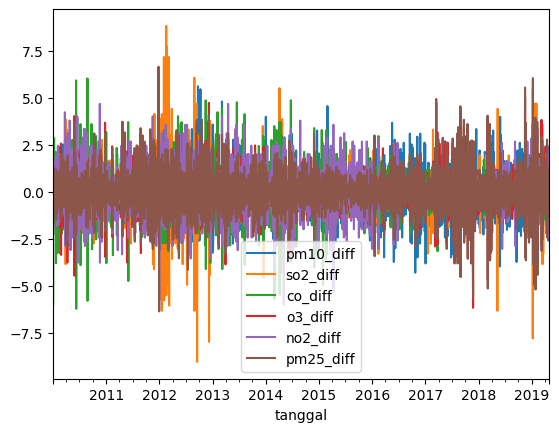

In [65]:
train_sc.plot()

In [66]:
train_sc.shape

(3213, 6)

In [67]:
test_sc.shape

(958, 6)

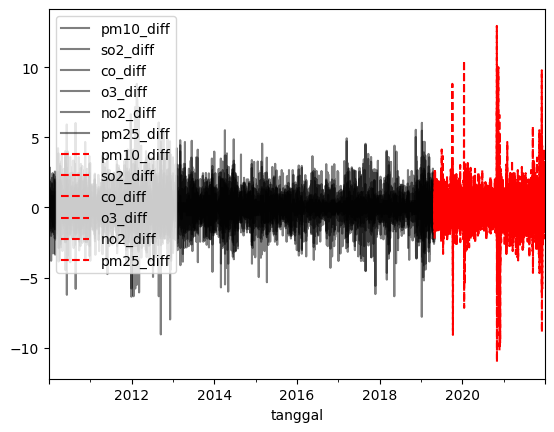

In [68]:
ax = train_sc.plot(style='k', alpha=0.5, label='train')
test_sc.plot(ax=ax, style='r--', label='test')
plt.legend(); plt.show()

In [69]:
model = VAR(endog=train_sc)
res = model.select_order(maxlags=10)
res.summary()

,AIC,BIC,FPE,HQIC
0,-2.134,-2.123,0.1183,-2.130
1,-2.924,-2.845,0.05371,-2.896
2,-3.287,-3.139,0.03735,-3.234
3,-3.505,-3.289,0.03004,-3.428
4,-3.628,-3.343,0.02658,-3.526
5,-3.723,-3.370*,0.02416,-3.597
6,-3.791,-3.370,0.02258,-3.640
7,-3.817,-3.328,0.02199,-3.642*
8,-3.824,-3.267,0.02183,-3.625
9,-3.834,-3.208,0.02163,-3.610


In [ ]:
res.selected_orders

{'aic': 10, 'bic': 6, 'hqic': 7, 'fpe': 10}

In [70]:
print(f'AIC: {res.aic} , BIC: {res.bic}, \
      HQ: {res.hqic}, FPE: {res.fpe}')

AIC: 10 , BIC: 5,       HQ: 7, FPE: 10


In [72]:
results = model.fit(maxlags=10, ic='aic')

In [73]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Feb, 2024
Time:                     01:44:10
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -3.15217
Nobs:                     3203.00    HQIC:                  -3.59725
Log likelihood:          -20743.8    FPE:                  0.0213659
AIC:                     -3.84599    Det(Omega_mle):       0.0190793
--------------------------------------------------------------------
Results for equation pm10_diff
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.002025         0.015418            0.131           0.895
L1.pm10_diff         -0.465205         0.023701          -19.628           0.000
L1.so2_diff           0.025132         0.017635         

In [74]:
type(results)

statsmodels.tsa.vector_ar.var_model.VARResultsWrapper

In [75]:
lag_order = results.k_ar
lag_order

10

In [76]:
results.params

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
const,0.002025,-0.000289,0.006491,-0.000466,0.001199,0.001844
L1.pm10_diff,-0.465205,-0.097242,-0.009195,0.058731,0.036679,0.064442
L1.so2_diff,0.025132,-0.404639,0.001907,-0.003802,0.024652,0.001030
L1.co_diff,-0.099225,-0.006671,-0.723960,-0.021762,-0.010721,-0.040233
L1.o3_diff,0.210046,-0.021741,0.052011,-0.461221,0.164066,0.185461
...,...,...,...,...,...,...
L10.so2_diff,-0.013322,-0.046438,0.009774,0.006704,-0.016369,0.004561
L10.co_diff,0.005246,0.013086,-0.093578,0.036165,0.023401,0.020168
L10.o3_diff,-0.055631,-0.031024,-0.051460,-0.059071,-0.048255,-0.002272
L10.no2_diff,0.036515,-0.005106,0.045820,-0.018925,-0.023793,-0.004614


In [77]:
train_sc[-lag_order:]

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,
2019-04-22,-0.243510,0.000086,0.107258,-0.151102,-1.556073,-0.165806
2019-04-23,0.812907,1.928022,0.107258,-0.050649,0.222533,0.554105
2019-04-24,-0.649825,-1.652431,0.212904,-0.552916,1.111836,-0.442695
2019-04-25,1.869324,0.826344,1.691954,2.209552,-0.666770,1.274016
2019-04-26,-2.600133,-1.652431,-1.477439,0.351165,2.223465,0.111083
2019-04-27,0.894170,0.275505,0.952429,-1.758356,-2.445375,-1.273361
2019-04-28,0.406592,-0.550753,1.163722,0.300938,0.000208,0.277216
2019-04-29,0.325330,0.550925,-0.737914,0.501845,1.778813,0.221839
2019-04-30,-0.893613,-1.101592,-0.632268,-0.000422,0.444859,-0.276561


<Axes: xlabel='tanggal'>

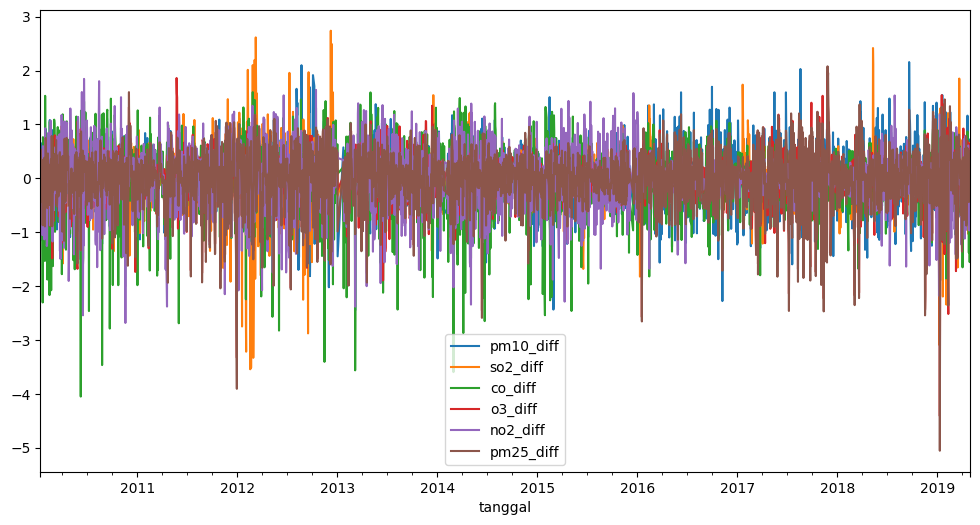

In [85]:
results.fittedvalues.plot(figsize=(12,6))

array([<Axes: xlabel='tanggal'>, <Axes: xlabel='tanggal'>,
       <Axes: xlabel='tanggal'>, <Axes: xlabel='tanggal'>,
       <Axes: xlabel='tanggal'>, <Axes: xlabel='tanggal'>], dtype=object)

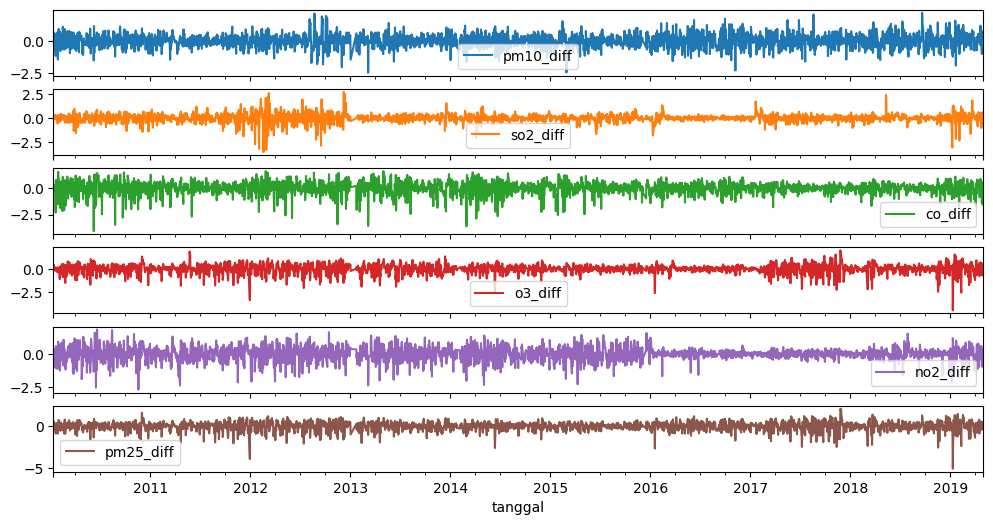

In [84]:
results.fittedvalues.plot(figsize=(12,6), subplots=True)

In [86]:
past_y = train_sc[-lag_order:].values
n = test_sc.shape[0]
forecast = results.forecast_interval(past_y, n)

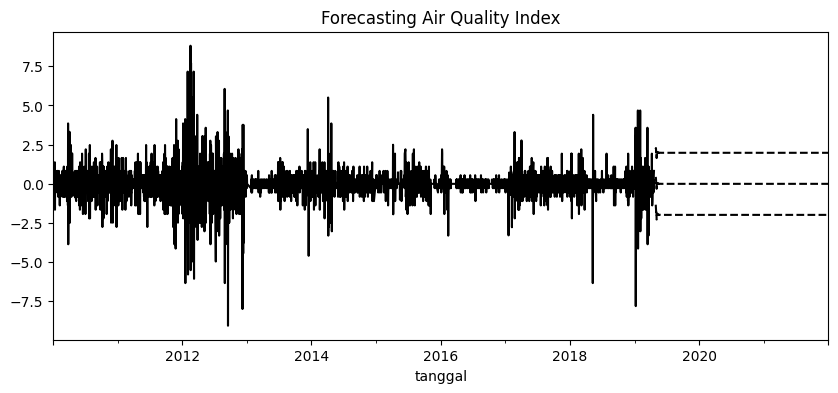

In [87]:
forecast, lower, upper = results.forecast_interval(past_y, steps=n)

idx = test.index
style = 'k--'
ax = train_sc.iloc[:-lag_order, 1].plot(figsize=(10, 4), style='k')
pred_forecast  = pd.Series(forecast[:, 1], index=idx).plot(ax=ax, style=style)
pred_lower = pd.Series(lower[:, 1], index=idx).plot(ax=ax, style=style)
pred_upper  = pd.Series(upper[:, 1], index=idx).plot(ax=ax, style=style)
plt.title('Forecasting Air Quality Index')
plt.show()

In [88]:
test_sc

,pm10_diff,so2_diff,co_diff,o3_diff,no2_diff,pm25_diff
tanggal,,,,,,
2019-05-01,0.569118,-0.275334,-0.526621,0.300938,-2.223050,0.332594
2019-05-02,-1.787505,0.550925,-1.054853,-1.758356,-1.333747,-1.494872
2019-05-03,1.137958,2.754281,1.058076,1.154792,2.445791,0.830994
2019-05-04,0.812907,-0.826173,0.846783,-0.653369,-0.444444,0.498727
2019-05-05,-1.056139,-1.377012,0.212904,2.661593,0.222533,1.717038
...,...,...,...,...,...,...
2021-12-27,1.381747,2.754281,0.424197,-0.100875,1.111836,0.997127
2021-12-28,-0.080985,-2.203271,0.001611,-0.100875,-0.444444,-0.331939
2021-12-29,-1.624979,0.275505,-0.526621,0.300938,-0.444444,-0.608828


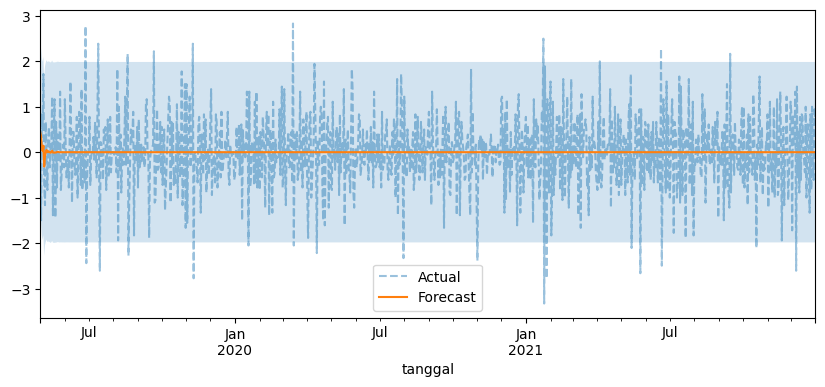

In [90]:
test_sc['pm25_diff'].plot(style='--', alpha=0.45, figsize=(10, 4)).plot()
pd.Series(forecast[ :, 1], index=test_sc.index).plot()
plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.2)
plt.legend(['Actual', 'Forecast'])

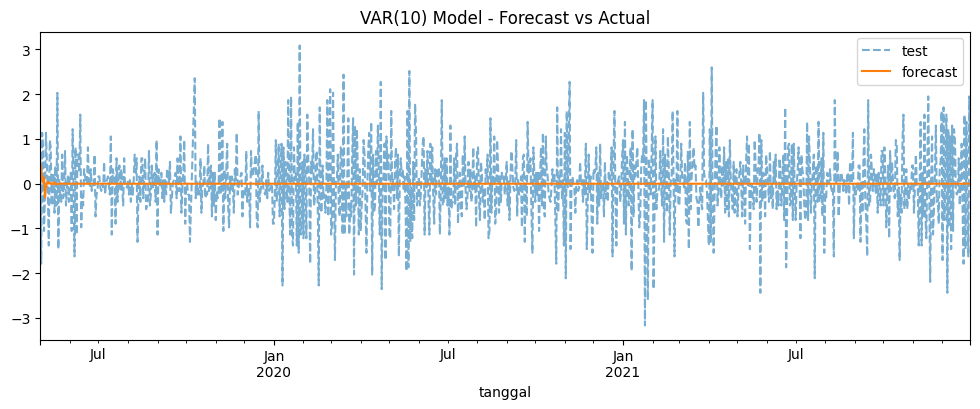

In [91]:
index = test_sc.index
plt.title('VAR(10) Model - Forecast vs Actual')
ax = test_sc['pm10_diff'].plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast[:, 1], index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast']); plt.show()